In [65]:
import numpy as np
from scipy.stats import genpareto
import matplotlib.pyplot as plt
from scipy.stats import expon,poisson
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import seaborn as sns 
import statsmodels.api as sm
import scipy.stats as stats
import Hawkes as hk
import array as arr
from scipy.integrate import quad
import random
plt.rcParams["figure.figsize"] = (10,5)
import pathlib
import sys
from copy import deepcopy

from scipy import integrate
from scipy.stats import multivariate_normal
import numpy.linalg as npl

from scipy.stats import  t 
from tqdm import tqdm
#from utilsInference import *

import sys


# sys.path.insert(0, r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Code')
# from ThresholdCalibration import *
# sys.path.insert(0, r'C:\Users\nmadhar\Desktop\GANEV\ExtremalDependence')
# from utilsExtremeDependence import *

sns.set_theme(style='white')


# I. Conditional Simulation Algorithm 

In [66]:
# Avec correction du 15/02
def CondSimulationExtremes(k,w,DeltaMatrix,ExcessStand,M):
    checkStep = []
    nDELTA,K = DeltaMatrix.shape
    Wk = np.zeros(M)
    if k != 0:
        w_wo_k = np.concatenate([w[0:k],w[k+1:]])
        kloc = 0
        idxDelta = k-1
    else:
        w_wo_k = w[1:]
        kloc =  (K+1) - 1
        idxDelta = k
    istar = np.argmax(w_wo_k) 
    istarAll = list(w).index(w_wo_k[istar])
    max_wo_k = np.max(w_wo_k)
    print(kloc)
    if max_wo_k > 0:
        
        if (istarAll == kloc): 
            checkStep.append(0)
        
            Tpos = set(list(np.arange(nDELTA)[np.delete(ExcessStand,k,1)[:,kloc]>0]))
            Tmax = set(list(np.arange(nDELTA)[np.argmax(np.delete(ExcessStand,k,1),axis=1)==kloc]))
            T = list(Tpos&Tmax)
            DELTAW1max = DeltaMatrix.iloc[T,:]
            Npos = DELTAW1max.shape[0]
            deltaSim = DELTAW1max.iloc[np.random.choice(list(np.arange(Npos)),M),idxDelta].values
            Wk = w[kloc] - deltaSim
        else :
            checkStep.append(1)
            
            for i in range(M):

                delta_star = w[kloc] - w_wo_k[istar]
                cond = True
                while cond:
                    delta_k = DeltaMatrix.iloc[np.random.choice(list(np.arange(nDELTA)),1),idxDelta].values[0]
                    u = stats.uniform.rvs()
                    cond = u > (np.exp(delta_k)*(delta_star>delta_k) + np.exp(delta_star)*(delta_star<delta_k))

                Wk[i] = w[kloc] - delta_k
    else:
        
        for i in tqdm(range(M)):
            checkStep.append(2)
            cond = True
            while cond:
                delta_k = DeltaMatrix.iloc[np.random.choice(list(np.arange(nDELTA)),1),idxDelta].values[0]
                u = stats.uniform.rvs()
                cond = u > (np.exp(delta_k)*(delta_k<w[kloc]))
            Wk[i] = w[kloc] - delta_k
    return Wk,checkStep

In [67]:

def prodInd(j,deltaMatrix):
    vectDelta_j = list(deltaMatrix[:,j])
    vectDelta_j.remove(vectDelta_j[j])
    return np.prod(np.array(vectDelta_j)<0)
def ComputeWk(k,deltaMatrix):
    K = deltaMatrix.shape[0]
    Delta = list(deltaMatrix[k,:])
    Delta.remove(Delta[k])
    Ind = [prodInd(j,deltaMatrix)  for j in range(K) if j != k]
    WwoE = np.dot(np.array(Delta),np.array(Ind))
    return WwoE

def DeltaMatrix(i,DELTA,K):
    deltaMatrix_i = np.zeros((K,K))
    deltaMatrix_i[0,1:] = DELTA.iloc[i,:]
    deltaMatrix_i[:,0] = - deltaMatrix_i[0,:] 
    for k in range(1,K):
        for l in range(k,K):
            if k != l:
                deltaMatrix_i[k,l] = deltaMatrix_i[0,l] - deltaMatrix_i[0,k]
                deltaMatrix_i[l,k] = -deltaMatrix_i[k,l]

    return deltaMatrix_i

def simulation(sample,M,replacing=False):
    N,K = sample.shape
    DELTA = pd.DataFrame(columns=np.arange(K-1),index=np.arange(N))
    newSample = pd.DataFrame(columns=np.arange(K),index=np.arange(M))
    for k in range(0,K-1):
        DELTA.iloc[:,k] = sample.iloc[:,0] - sample.iloc[:,k+1]
    if replacing :
        Msample = DELTA.iloc[np.random.choice(list(np.arange(N)),M),:]
    else :
        Msample = DELTA.iloc[random.sample(list(np.arange(N)),M),:]
    E = expon.rvs(size=M)

    for m in range(M):
        deltaMatrix_m = DeltaMatrix(m,Msample,K)
        for k in range(K):
            newSample.iloc[m,k] = E[m] +  ComputeWk(k,deltaMatrix_m)
    return newSample

---
# $K = 3$
---

We define the conditional distribution when the distribution of $T$ is a centered Guassian distribtion with some fixed correlation matrix.

In [68]:
def pdfNormMulti(x,xwok,mu,cov):
    k = len(xwok) +1
    X = np.array([x,xwok[0]])
    return (2*np.pi)**(-k/2) * npl.det(cov)**(-1/2) * np.exp(-0.5*np.dot(np.dot((X - mu).T ,npl.inv(cov)),(X - mu)) )


In [69]:
def pdf_condiK3(zk,z_wok,mu,cov,B = np.array([[1,-1,0],[1,0,-1]])):
    N = len(zk)
    z = np.array([z_wok[0],zk,z_wok[-1]])
    delta = np.zeros((N,2))
    delta[:,0] = z_wok[0] - zk
    delta[:,1] = z_wok[0] -z_wok[-1]

    locdelta = np.dot(B,mu.T)
    covdelta = np.dot(np.dot(B,cov),B.T)
    if max(z_wok)>0:
        if max(z_wok) == z_wok[0] :

            exp_pdfdelta =  lambda x: np.exp(x) * pdfNormMulti(x,[delta[0,1]],locdelta,covdelta)
            pdfdelta =  lambda x: pdfNormMulti(x,[delta[0,1]],locdelta,covdelta)
            K = integrate.quad(exp_pdfdelta,-np.inf,0)[0]  + integrate.quad(pdfdelta,0,np.inf)[0]
            pdf = 1/K * ((delta[:,0]>0) + np.exp(delta[:,0]) * (delta[:,0]<0)) * multivariate_normal.pdf(delta,mean=locdelta,cov=covdelta)
        elif max(z_wok)==z_wok[-1]:
            zstar = max(z_wok)
            exp_pdfdelta =  lambda x: np.exp(x) * pdfNormMulti(x,[delta[0,1]],locdelta,covdelta)
            pdfdelta =  lambda x: pdfNormMulti(x,[delta[0,1]],locdelta,covdelta)
            K = integrate.quad(exp_pdfdelta,-np.inf,z_wok[0] -zstar )[0]  + np.exp(z_wok[0] -zstar) * integrate.quad(pdfdelta,z_wok[0] -zstar,np.inf)[0]
            deltastar = z_wok[0] - zstar
            pdf = 1/K * ((delta[:,0]<deltastar) *  np.exp(delta[:,0]) +  np.exp(deltastar)*(delta[:,0]>=deltastar)) * multivariate_normal.pdf(delta,mean=locdelta,cov=covdelta)
    else:
        exp_pdfdelta =  lambda x: np.exp(x)*pdfNormMulti(x,[delta[0,1]],locdelta,covdelta)
        Kz1 = integrate.quad(exp_pdfdelta,-np.inf,z_wok[0])[0] 
        pdf = (np.exp(delta[:,0])* multivariate_normal.pdf(delta,mean=locdelta,cov=covdelta)/Kz1) * (delta[:,0]<z_wok[0])
        
    return pdf

In [70]:
K =  3 # dimension of the random vector 
N = 10000 # size of the original sample
M = 10000 # size of the sample generated with the conditional simulation algorithm 

# Gaussian distribution Parameter
B = np.array([[1,-1,0],[1,0,-1]])
cov3 = np.array([[1,np.sqrt(0.6),np.sqrt(0.8)],[np.sqrt(0.6),1,np.sqrt(0.5)],[np.sqrt(0.8),np.sqrt(0.5),1]])
mu = np.zeros(K)

# Simulation of original sample under the parametric framework
T = np.random.multivariate_normal(np.zeros(3),cov = cov3,size=N)
Tmax = np.array([max(T[i,:]) for i in range(N)])
E = expon.rvs(size=N)
Z = np.zeros((N,3))
Z[:,0] = E + T[:,0] - Tmax
Z[:,1] = E + T[:,1] - Tmax
Z[:,2] = E + T[:,2] - Tmax


ExcessStand = Z
nStand,K = ExcessStand.shape
DELTA_1 = pd.DataFrame(columns=np.arange(K-1),index=np.arange(nStand))
for k in range(0,K-1):
    DELTA_1.iloc[:,k] = ExcessStand[:,0] - ExcessStand[:,k+1]

## 1. Conditional Simulation under the first case: $w_{\star} = w_1$

In [71]:
list_idx = np.arange(N)[np.argmax(Z,axis=1)==0][:20] # defining the list of index for which w_star = w_1


[1.04284094 0.90568229 0.84480326]
0


C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.
C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


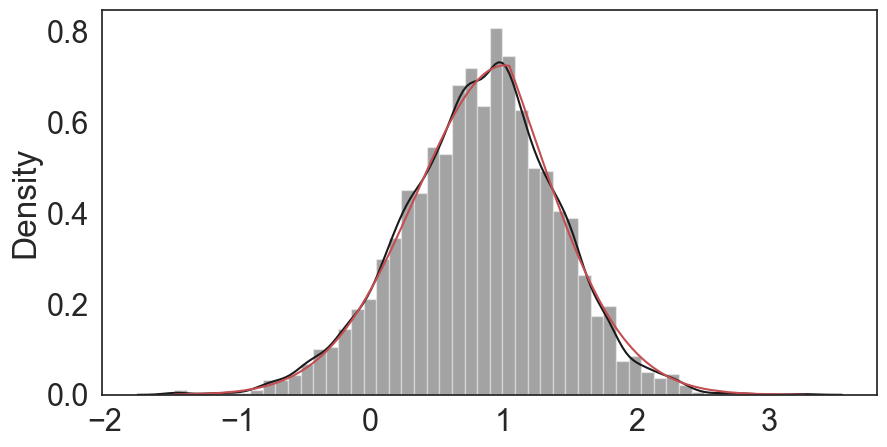

In [27]:
zobs = Z[random.choice(list_idx),:]
print(zobs)
Z2COndK3,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStand,M)
ax = sns.distplot(Z2COndK3,color='k',kde=True)
sortedZ2COndK3 = np.sort(Z2COndK3)
ax.plot(sortedZ2COndK3,pdf_condiK3(sortedZ2COndK3,[zobs[0],zobs[2]],mu,cov3,B = np.array([[1,-1,0],[1,0,-1]])),c='r')
ax.set_ylabel('Density',fontsize=24)
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)
#plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\CondSimParametric\GaussianT_case1_1.png')#,bbox_inches='tight')

## 2. Conditional Simulation under the second case: $w_{\star} = w_3$

In [72]:
list_idx = np.arange(N)[np.argmax(Z,axis=1)==2][0:20]  # defining the list of index for which w_star = w_3


[1.56202292 1.26278132 1.57186633]
0


C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.
C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


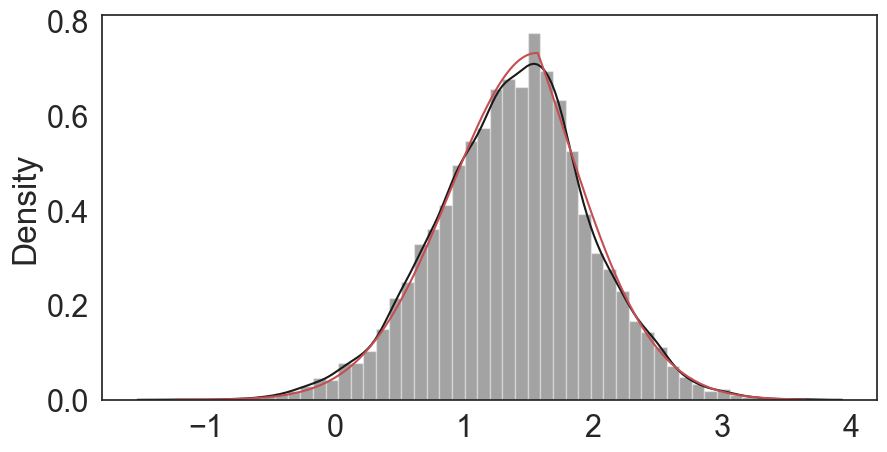

In [73]:
zobs = Z[random.choice(list_idx),:]
print(zobs)
Z2COndK3,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStand,M)
ax = sns.distplot(Z2COndK3,color='k')
sortedZ2COndK3 = np.sort(Z2COndK3)
ax.plot(sortedZ2COndK3,pdf_condiK3(sortedZ2COndK3,[zobs[0],zobs[2]],mu,cov3,B = np.array([[1,-1,0],[1,0,-1]])),c='r')
ax.set_ylabel('Density',fontsize=24)
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)
#plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\CondSimParametric\GaussianT_case2_1.png')

## 3. Conditional Simulation under the second case: $w_{\star} <0$

In [79]:
list_idx = np.arange(N)[np.max(np.delete(Z,1,1),axis=1)<0][:20]  # defining the list of index for which w_star < 0 

[-0.0658413   0.14316475 -0.31835239]
0


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 214.54it/s]
C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.
C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separ

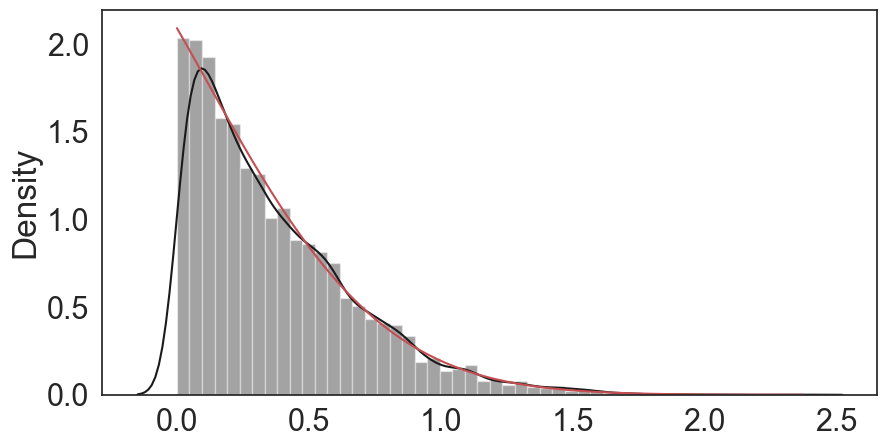

In [80]:
zobs = Z[random.choice(list_idx),:]
print(zobs)
Z2COndK3,_ = CondSimulationExtremes(1,zobs,DELTA_1,ExcessStand,M)
ax = sns.distplot(Z2COndK3,color='k')
sortedZ2COndK3 = np.sort(Z2COndK3)
ax.plot(sortedZ2COndK3,pdf_condiK3(sortedZ2COndK3,[zobs[0],zobs[2]],mu,cov3,B = np.array([[1,-1,0],[1,0,-1]])),c='r')
ax.set_ylabel('Density',fontsize=24)
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)
#plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\CondSimParametric\GaussianT_case3_1.png')